# Implements encoder/decoder for weak lensing outputs

The major idea is to see if I can compress the data in the snapshot files.
The result is that the compression of many different algorithms based on CNNs (of different depths) is not so much different than averaging neighboring cells (as shown at the end).  This in retrospect is not so surprising as there are differences on the cell scale in the maps that make compression challenging.

Set configurations for google COLAB if running there

In [3]:
import os


use_COLAB = 0 #1 is for on colab, and 2 is for on local machine but using colab

if use_COLAB >= 1:
  if use_COLAB == 2: # for running in VS CODE
      from colabcode import ColabCode
      ColabCode(port=10000)
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)


## extract tarfiles if necessary and set specs for run



In [4]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#whether we are training or loading saved
train = True
load_saved = 1

# Specify the directory containing the .tar files
if use_COLAB >= 1:
    directory_path = './columbialensing/'
else:
        directory_path = '../weaklensing_ML/columbialensing/'
number_batches = 10
normalize_by_RMS = False #set to one if you want to renormalize by RMS

# image_size
image_size = 1024
sub_image_size = 32 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations
number_fits_files = 16 # just sto start


number_subimages_across =image_size//sub_image_size




#extracts only if indicated (could make this more elegant by checking to see if they exist)
extract_tarfiles = False  #if I need to extract tarfiles
suffix = f"_{image_size}"
run_suffix = rf"im{image_size}"
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)




Num GPUs Available:  1


# Read into memory the data

In [5]:
#import wl_auxiliary

def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float16)

number_subimages_total = 0
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        if idx >= number_fits_files:
            break

        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]/RMS
                number_subimages_total +=1



    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension



reading in Om0.268_si0.801
RMS=0.018752897158265114


2024-10-27 11:54:43.017884: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-27 11:54:43.017903: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-10-27 11:54:43.017908: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-10-27 11:54:43.017922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-27 11:54:43.017931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


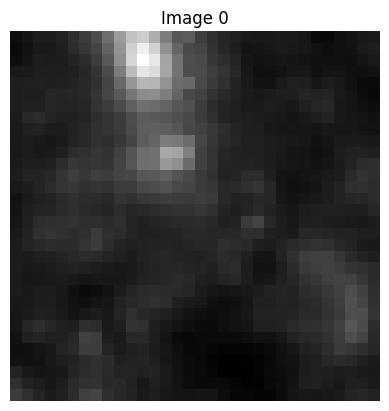

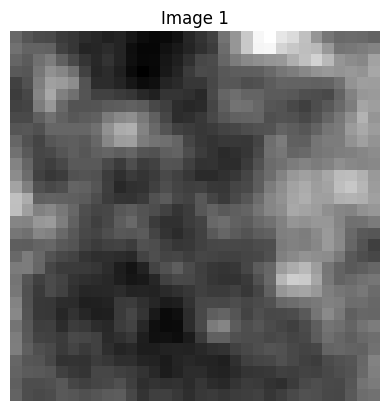

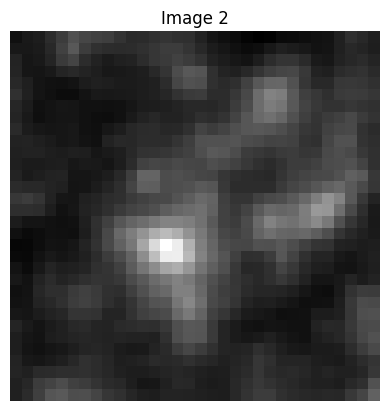

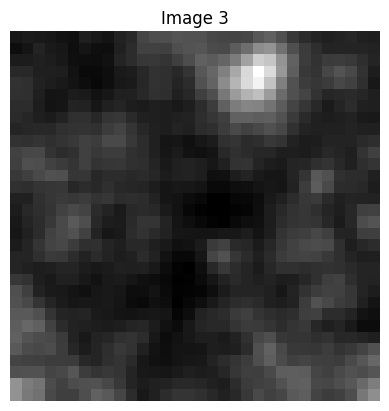

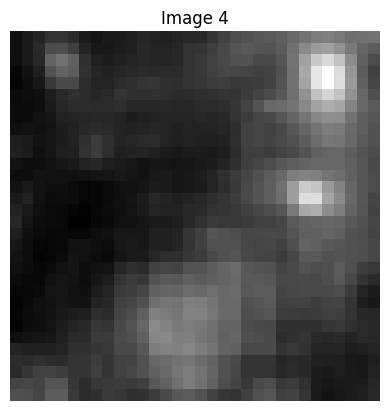

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

# Number of images you want to display
num_images_to_display = 5

for i in range(num_images_to_display):
    # Extract the i-th image tensor
    image_tensor = WL_tensor[i, :, :, 0]
    # Use TensorFlow operations if needed (optional)
    # Display the image
    plt.imshow(image_tensor, cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()


In [7]:
print("number_subimages_across =", number_subimages_across )
print("total number of images =", number_subimages_across*number_subimages_across*number_fits_files *len(all_directories), number_subimages_total)
np.shape(WL_tensor)

number_subimages_across = 32
total number of images = 16384 512


TensorShape([16384, 32, 32, 1])

# Renormalize the image data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import tensorflow as tf


# Implement Welford's algorithm for numerically stable mean and variance calculation
def welford_algorithm(data):
    n = 0
    mean = 0.0
    M2 = 0.0

    for x in data:
        n += 1
        delta = x - mean
        mean += delta / n
        delta2 = x - mean
        M2 += delta * delta2

    variance = M2 / (n - 1) if n > 1 else float('nan')
    return mean, variance

calculate_statistics = False

if calculate_statistics:
    # Assuming WL_tensor is a TensorFlow tensor of floating-point numbers

    # Convert the TensorFlow tensor to a NumPy array
    WL_tensor_np = WL_tensor.numpy()
    WL_tensor_np = WL_tensor_np[::1000, :, :, :]  # Downsample the tensor for faster computation

    # Check for NaNs and Infinities
    num_nans = np.isnan(WL_tensor_np).sum()
    num_infs = np.isinf(WL_tensor_np).sum()
    print(f"Number of NaNs: {num_nans}")
    print(f"Number of Infinities: {num_infs}")


    # Inspect the range of values
    min_value = WL_tensor_np.min()
    max_value = WL_tensor_np.max()
    print(f"Min value: {min_value}")
    print(f"Max value: {max_value}")

    # Check the shape of the tensor
    tensor_shape = WL_tensor_np.shape
    print(f"Tensor shape: {tensor_shape}")

    # Manually calculate the mean and variance
    mean_value = np.mean(WL_tensor_np)
    variance_value = np.var(WL_tensor_np)
    print(f"Mean value: {mean_value}")
    print(f"Variance value: {variance_value}")


    # Flatten the tensor to 1D for easier processing
    WL_tensor_flat = WL_tensor_np.flatten()




    # Calculate mean and variance using Welford's algorithm
    mean_value, variance_value = welford_algorithm(WL_tensor_flat)
    print(f"Mean value: {mean_value}")
    print(f"Variance value: {variance_value}")


    # Calculate the standard deviation
    std_dev = np.std(WL_tensor_np)
    print(f"Standard Deviation: {std_dev}")

    DO_KDE= True
    if DO_KDE:
        # Flatten the tensor to 1D for PDF calculation
        WL_tensor_flat = WL_tensor_np.flatten()

        # Calculate the PDF using Gaussian Kernel Density Estimation
        kde = gaussian_kde(WL_tensor_flat)
        x_values = np.linspace(WL_tensor_flat.min(), WL_tensor_flat.max(), 1000)
        pdf_values = kde(x_values)

        # Plot the PDF
        plt.figure(figsize=(8, 6))
        plt.semilogx(x_values, pdf_values, label='PDF')
        plt.hist(WL_tensor_flat, bins=50, density=True, alpha=0.6, color='g', label='Histogram')
        plt.title('Probability Density Function of WL_tensor')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

# Motivated binning method that partitions so that variance in each bin should be the same

In [81]:
import numpy as np
import tensorflow as tf

# Ensure WL_tensor_flat is a NumPy array
if isinstance(WL_tensor_flat, tf.Tensor):
    WL_tensor_flat_np = WL_tensor_flat.numpy()
else:
    WL_tensor_flat_np = WL_tensor_flat

# Step 1: Sample a Subset of the Data
sample_size = 1000000  # Adjust based on available memory and desired accuracy
indices = np.random.choice(len(WL_tensor_flat_np), size=sample_size, replace=False)
sampled_data = WL_tensor_flat_np[indices]


# Step 2: Sort the Sampled Data
sorted_data = np.sort(sampled_data)
n = len(sorted_data)


#print("num zeros = ", np.sum(sampled_data == 0), np.sum(WL_tensor_flat_np == 0), np.sum(sorted_data ==0))

#print("sorted_data =", sorted_data)

# Step 3: Compute Cumulative Sums and Cumulative Sum of Squares
cum_sum = np.cumsum(sorted_data, dtype=float)
cum_sum_sq = np.cumsum(sorted_data**2, dtype=float)

# Step 4: Compute Total Variance and Target Variance per Bin
target_std = .01
num_bins= 50 # just a guess to start

for iiter in range(3): # iterate five times to reach target std

    target_variance_per_bin = target_std**2/ num_bins

    print(f"Target Variance: {target_variance}")
    print(f"Target Variance per Bin: {target_variance_per_bin}")


    # Step 5: Find Bin Edges
    bin_edges = []
    num_points_arr = []
    total_variance_bin_arr = []
    mean_bin_arr = []

    start_index = 0
    while start_index < n:
        found = False
        for end_index in range(start_index + 10, n):
            num_points = end_index - start_index + 1
            #if num_points <= 3:
            #    continue
            # Sum and sum of squares in the bin
            sum_bin = cum_sum[end_index] - (cum_sum[start_index - 1] if start_index > 0 else 0)
            sum_sq_bin = cum_sum_sq[end_index] - (cum_sum_sq[start_index - 1] if start_index > 0 else 0)
            # Mean and variance in the bin
            mean_bin = sum_bin / num_points
            total_variance_bin = (sum_sq_bin - num_points*mean_bin**2)/(num_points-1)*num_points/n  #total contribute to variance
            if total_variance_bin >= target_variance_per_bin:
                bin_edges.append(sorted_data[end_index])
                num_points_arr.append(num_points)
                total_variance_bin_arr.append(total_variance_bin)
                mean_bin_arr.append(mean_bin)
                #print("sums = ",  sum_bin , sum_sq_bin, mean_bin, sum_sq_bin / num_points, num_points, "total_variance_bin = ", total_variance_bin, target_variance_per_bin, num_points/n, ((sum_sq_bin / num_points) - mean_bin**2) )
                #print("indexes =", start_index, end_index, cum_sum[end_index], cum_sum_sq[start_index - 1]) 
                start_index = end_index + 1
                found = True
                break
        if not found:
            # Include all remaining data in the last bin
            bin_edges.append(tf.reduce_max(WL_tensor)) #       sorted_data[-1])
            break

    num_bins = len(bin_edges)
    print("num bins=", num_bins)



# Step 6: Digitize the Original Data Using Bin Edges
# Convert bin_edges to numpy array for consistency
bin_edges = np.array(bin_edges)

# Use np.digitize to find bin indices for the entire dataset
bin_indices = np.digitize(WL_tensor_flat_np, bin_edges, right=True)-1

# Adjust bin_indices to ensure they are within the valid range
# Since mean_values has length len(bin_edges) + 1, bin_indices should be in [0, len(bin_edges)]
#may be necessary since our bins are not based on everything
bin_indices = np.clip(bin_indices, 0, len(bin_edges))


# Digitize the tensor values according to the binning scheme
#bin_indices = tf.searchsorted(bin_edges, WL_tensor_flat, side='right') - 1


#let's calculate the mean we expect in each bin
#MIGHT NEED TO GAURD AGAINST ZEROS
mean_values = [np.mean(WL_tensor_flat[bin_indices == index]) for index in range(len(bin_edges)-1)]




print("mean values = ", mean_values)
print("bin_edges = ", bin_edges)
print("num_points = ", num_points_arr)
print("total_variance_bin =", total_variance_bin_arr)

encoded_tensor = tf.gather(mean_values, bin_indices) #realization of quantized tensor


#reshape
bin_indices = tf.reshape(bin_indices, [number_images,  sub_image_size*sub_image_size])


# Compute mean values
# mean_values = np.zeros(len(bin_edges) + 1)
# for i in range(len(mean_values)):
#     indices_in_bin = bin_indices == i
#     if np.any(indices_in_bin):
#         mean_values[i] = np.mean(WL_tensor_flat_np[indices_in_bin])
#     else:
#         # Handle empty bins if necessary
#         mean_values[i] = 0

# # Map bin indices to mean values
# encoded_tensor_np = mean_values[bin_indices]

# # If you need to convert back to a TensorFlow tensor
# encoded_tensor = tf.convert_to_tensor(encoded_tensor_np, dtype=WL_tensor_flat.dtype)

# # Compute Quantization Error
# 
# 
diff_tensor = encoded_tensor - WL_tensor_flat

# Compute the standard deviation of the quantization error
std_quantized = tf.math.reduce_std(diff_tensor).numpy()

# Convert indices to a TensorFlow tensor
indices_tf = tf.constant(indices, dtype=tf.int32)
# Use tf.gather to index diff_tensor
std_quantized_sampled = tf.math.reduce_std(tf.gather(diff_tensor, indices_tf)).numpy()

print("##########################################")
print("Standard Deviation of Quantization Error:", std_quantized, std_quantized_sampled, np.sum(total_variance_bin_arr)**.5)
print("##########################################")
# If needed, reshape encoded_tensor back to the original tensor shape
# encoded_tensor = tf.reshape(encoded_tensor, WL_tensor.shape)

#just to check quantization works
print(encoded_tensor[-10:])
print(WL_tensor_flat[-10:])


print(diff_tensor[-10:])


print(num_points_arr, np.sum(num_points_arr))
print(total_variance_bin_arr, np.sum(total_variance_bin_arr))


Target Variance: 0.1
Target Variance per Bin: 2e-06
num bins= 122
Target Variance: 0.1
Target Variance per Bin: 8.19672131147541e-07
num bins= 166
Target Variance: 0.1
Target Variance per Bin: 6.024096385542169e-07
num bins= 186
mean values =  [-1.493, -1.393, -1.335, -1.283, -1.242, -1.205, -1.17, -1.139, -1.108, -1.077, -1.05, -1.02, -0.985, -0.955, -0.9277, -0.902, -0.8794, -0.8564, -0.8296, -0.8037, -0.78, -0.7593, -0.745, -0.7275, -0.704, -0.682, -0.661, -0.639, -0.619, -0.5986, -0.577, -0.556, -0.535, -0.512, -0.488, -0.465, -0.443, -0.421, -0.398, -0.3765, -0.3547, -0.3325, -0.31, -0.2876, -0.2646, -0.2416, -0.2185, -0.1954, -0.1721, -0.1487, -0.1251, -0.10126, -0.0772, -0.0531, -0.0288, -0.004242, 0.02051, 0.0455, 0.0707, 0.096, 0.12164, 0.1476, 0.1737, 0.2001, 0.2268, 0.254, 0.2815, 0.3088, 0.3364, 0.364, 0.392, 0.4211, 0.4507, 0.4805, 0.5117, 0.543, 0.573, 0.6035, 0.6343, 0.665, 0.6973, 0.7295, 0.7603, 0.792, 0.8276, 0.8633, 0.899, 0.9355, 0.9736, 1.015, 1.055, 1.094, 1.131, 

In [11]:
print("np.shape(WL_tensor), np.shape(bin_indices) = ", np.shape(WL_tensor), np.shape(bin_indices), bin_indices.dtype)

np.shape(WL_tensor), np.shape(WL_tensor_binned), np.shape(bin_indices) =  (16384, 32, 32, 1) (16654944,) (16384, 1024) <dtype: 'int32'>


# Autoregressive image transformer 

## Simple autoencoder with sines and cosines sampling to Nyquist

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt


# Parameters for the network
n_trans_layers = 2  # Number of Transformer layers
number_channels = sub_image_size  # Embedding dimension (d_model)
act_string = 'relu'
dropout_rate = 0.1
L1weight = 0  #don't think need L1 and dropout  (I've tested and it performs best with this equal to zero)
num_classes = num_bins  # Set num_classes to num_bins: this is the number of values that can be populated
d_model = number_channels*2  # Embedding dimension
d_ff = d_model * 4  # Feed-forward network dimension
num_heads = 8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

# Custom Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, height, width, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.height = height
        self.width = width
        self.d_model = d_model
        self.supports_masking = True  # Enable masking support
        self.pos_encoding = self.positional_encoding(height, width, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'height': self.height,
            'width': self.width,
            'd_model': self.d_model,
        })
        return config

    def get_angles(self, pos):
        num_frequencies = self.d_model // 2
        frequencies = tf.linspace(0.0, np.pi, num_frequencies)
        frequencies = tf.cast(frequencies, tf.float32)
        angle_rates = frequencies[tf.newaxis, :]  # Shape: (1, num_frequencies)
        return pos * angle_rates  # pos: (positions, 1), angle_rates: (1, num_frequencies)

    def positional_encoding(self, height, width, d_model):
        position_x = tf.range(width, dtype=tf.float32)[:, tf.newaxis]  # Shape: (width, 1)
        position_y = tf.range(height, dtype=tf.float32)[:, tf.newaxis]  # Shape: (height, 1)

        angles_x = self.get_angles(position_x)  # Shape: (width, num_frequencies)
        angles_y = self.get_angles(position_y)  # Shape: (height, num_frequencies)

        sines_x = tf.math.sin(angles_x)
        cosines_x = tf.math.cos(angles_x)
        sines_y = tf.math.sin(angles_y)
        cosines_y = tf.math.cos(angles_y)

        pos_encoding_x = tf.concat([sines_x, cosines_x], axis=-1)  # Shape: (width, d_model)
        pos_encoding_y = tf.concat([sines_y, cosines_y], axis=-1)  # Shape: (height, d_model)

        pos_encoding_x = pos_encoding_x[tf.newaxis, :, :]  # Shape: (1, width, d_model)
        pos_encoding_y = pos_encoding_y[:, tf.newaxis, :]  # Shape: (height, 1, d_model)

        pos_encoding = pos_encoding_y + pos_encoding_x  # Shape: (height, width, d_model)

        pos_encoding = tf.reshape(pos_encoding, [1, height * width, d_model])

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        seq_length = input_shape[1]

        # Ensure the positional encoding matches the input sequence length
        return inputs + self.pos_encoding[:, :seq_length, :]

# Function to create the Transformer model
def create_autoregressive_transformer(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    seq_length = height * width - 1  # Subtract 1 for autoregressive prediction
    #inputs = layers.Input(shape=(seq_length,))  # Input tokens are integers
    inputs = layers.Input(shape=(None,), dtype=tf.int32)  # Accept variable-length sequences
    x = inputs

    # Embed the input tokens (indices)
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model, mask_zero=True)(x)  # Shape: (batch_size, seq_length, d_model)

    # Apply positional encoding
    x = PositionalEncoding(height, width, d_model)(x)

    # Create the causal mask once as a constant tensor
    #causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    #causal_mask = tf.cast(causal_mask, dtype=tf.bool)

    def create_causal_mask(x):
        seq_length = tf.shape(x)[1]
        causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
        return causal_mask

    causal_mask = layers.Lambda(create_causal_mask)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with causal masking
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=causal_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

seq_length = sub_image_size * sub_image_size

print("Shape of bin_indices:", bin_indices.shape)

# Prepare input and target sequences by shifting the data
input_sequences = bin_indices[:, :-1]  # All indices except the last one
target_sequences = bin_indices[:, 1:]  # All indices except the first one

# Create the model
autoregressive_transformer = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)

# Create the model
autoregressive_transformer_deep = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers*2,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)


autoregressive_transformer.summary()

autoregressive_transformer_deep.summary()

Shape of bin_indices: (16384, 1024)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 64)  │     11,904 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ embedding_1[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda[0][0],     │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 64)  │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, None, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None, 64)  │          0 │ add_4[0][0],      │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                 

 Total params: 123,962 (484.23 KB)

 Trainable params: 123,962 (484.23 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 64)  │     11,904 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ embedding_2[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, None)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, None, 64)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, None, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, None, 64)  │     16,448 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, None, 64)  │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, None, 64)  │          0 │ add_8[0][0],      │
│                     │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 223,930 (874.73 KB)

 Trainable params: 223,930 (874.73 KB)

 Non-trainable params: 0 (0.00 B)

## Compile models

In [87]:
# Compile the model with cross-entropy loss
autoregressive_transformer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Compile the model with cross-entropy loss
autoregressive_transformer_deep.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Train models

In [88]:

# Optionally split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_sequences.numpy(), target_sequences.numpy(), test_size=0.1, random_state=42
)

# Train the model
history = autoregressive_transformer.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,  # Adjust epochs as needed
    verbose=1
)


# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5


/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream

922/922 ━━━━━━━━━━━━━━━━━━━━ 500s 536ms/step - accuracy: 0.0439 - loss: 3.9466 - val_accuracy: 0.0735 - val_loss: 3.2685
Epoch 2/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 521s 564ms/step - accuracy: 0.0747 - loss: 3.2307 - val_accuracy: 0.0906 - val_loss: 3.0423
Epoch 3/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.0876 - loss: 3.0709

### Let's fit the deep model

In [13]:


# Train the model
history = autoregressive_transformer_deep.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,  # Adjust epochs as needed
    verbose=1
)


# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5


/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream

922/922 ━━━━━━━━━━━━━━━━━━━━ 982s 1s/step - accuracy: 0.0871 - loss: 3.2729 - val_accuracy: 0.1239 - val_loss: 2.7536
Epoch 2/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1021s 1s/step - accuracy: 0.1277 - loss: 2.7058 - val_accuracy: 0.1580 - val_loss: 2.4666
Epoch 3/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1073s 1s/step - accuracy: 0.1560 - loss: 2.4744 - val_accuracy: 0.1778 - val_loss: 2.3402
Epoch 4/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1109s 1s/step - accuracy: 0.1720 - loss: 2.3700 - val_accuracy: 0.1864 - val_loss: 2.2889
Epoch 5/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.1809 - loss: 2.3185 - val_accuracy: 0.1920 - val_loss: 2.2581
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 471ms/step - accuracy: 0.1798 - loss: 2.3376
Validation Loss: 2.3372  bits per pixel : 3.3719
Validation Accuracy: 0.1790


# Visualize images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Much slower code that I don't use anymore
def autoregressive_predict(model, original_sequence, sequence_length):
    """
    Generate predictions using the autoregressive model, one step at a time,
    using the original sequence up to the current position as context.
    """
    predicted_sequence = []

    for i in range(1, sequence_length+1):
        # Prepare the context (all previous pixels)
        context = original_sequence[:i]

        # No padding required; model expects input of length seq_length
        # For positions where context is shorter, we need to pad or adjust the input
        # Since we're avoiding padding, we'll adjust the input sequence accordingly

        # Create a context of length 'i'
        model_input = np.array(context, dtype=np.int32)[np.newaxis, :]

        # Since the model expects input of shape (batch_size, seq_length),
        # we need to handle the varying lengths
        # One way is to slice the model to accept variable input lengths

        # Predict
        next_pixel_probs = model.predict(model_input, verbose=0)
        # Get the prediction for the current position
        next_pixel = np.argmax(next_pixel_probs[0, -1, :])
        predicted_sequence.append(next_pixel)

        if i % 100 == 0:
            print(f"Step {i}: Context length: {len(context)}, Predicted next pixel: {next_pixel}")

    return np.array(predicted_sequence)


#should be much faster....need to check
def autoregressive_predict_batched(model, original_sequence, sequence_length):
    """
    Generate predictions using the autoregressive model by batching inputs,
    which significantly speeds up the prediction process.
    """
    # Prepare all contexts at once
    contexts = [original_sequence[:i] for i in range(1, sequence_length + 1)]

    # Pad sequences to the same length
    max_len = sequence_length
    padded_contexts = tf.keras.preprocessing.sequence.pad_sequences(
        contexts, maxlen=max_len, padding='post', value=0
    )

    # Convert to array
    model_inputs = np.array(padded_contexts, dtype=np.int32)

    # Predict all at once
    next_pixel_probs = model.predict(model_inputs, verbose=0)

    # Extract the predictions
    predicted_sequence = []
    for i, context in enumerate(contexts):
        # Get the prediction for the current position
        seq_length = len(context)
        next_pixel = np.argmax(next_pixel_probs[i, seq_length - 1, :])
        predicted_sequence.append(next_pixel)

        if (i + 1) % 100 == 0:
            print(f"Step {i + 1}: Context length: {seq_length}, Predicted next pixel: {next_pixel}")

    return np.array(predicted_sequence)


def process_random_images(X_val, y_val, model, sub_image_size, num_samples=5):
    """
    Process and visualize random images from the validation set.
    """
    total_samples = len(X_val)
    random_indices = np.random.choice(total_samples, num_samples, replace=False)
    
    
    for i, idx in enumerate(random_indices):
        val_sample = X_val[idx]
        original_sequence = y_val[idx]
        
        # Determine the sequence length
        sequence_length = len(original_sequence)
        
        # Predict using the original sequence as context
        predicted_sequence = autoregressive_predict_batched(
            model,
            original_sequence,
            sequence_length,
        )
        
        print("val_sample and original_sequence shapes", np.shape(val_sample), np.shape(original_sequence), np.shape(predicted_sequence))
    
        visualize_autoregressive_prediction(original_sequence, predicted_sequence, sub_image_size, i+1)
        
        mse = np.mean((original_sequence - predicted_sequence)**2)
        mae = np.mean(np.abs(original_sequence - predicted_sequence))
        print(f"Sample {i+1}:")
        print(f"  Mean Squared Error: {mse:.4f}")
        print(f"  Mean Absolute Error: {mae:.4f}")
        print(f"  Original sequence shape: {original_sequence.shape}")
        print(f"  Predicted sequence shape: {predicted_sequence.shape}")
        print(f" fraction of pixles correct", np.sum(original_sequence - predicted_sequence == 0)/len(original_sequence))
        print("-----------------------------")


# The visualize_autoregressive_prediction function remains the same

def visualize_autoregressive_prediction(original_sequence, predicted_sequence, sub_image_size, index):
    """
    Visualize the original, predicted, and difference images with equal sizes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f'Sample {index}', fontsize=16)

    # Prepare images
    original_2d = sequence_to_image(original_sequence, sub_image_size, original=True)
    predicted_2d = sequence_to_image(predicted_sequence, sub_image_size, original=False)
    diff = original_2d - predicted_2d

    # Set up common parameters for imshow
    imshow_args = {'interpolation': 'nearest', 'aspect': 'equal'}

    # Visualize original sequence
    im1 = axes[0].imshow(original_2d, cmap='gray', **imshow_args)
    axes[0].set_title('Original Image')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Visualize predicted sequence
    im2 = axes[1].imshow(predicted_2d, cmap='gray', **imshow_args)
    axes[1].set_title('Predicted Image (Autoregressive)')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Visualize difference
    im3 = axes[2].imshow(diff, cmap='bwr', **imshow_args)
    axes[2].set_title('Difference (Original - Predicted)')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Remove axis ticks for cleaner look
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


def sequence_to_image(sequence, sub_image_size, original=True):
    """
    Convert a 1D sequence of length 1023 to a 2D image of size sub_image_size x sub_image_size,
    by prepending the first_token to the sequence.
    """
    # Concatenate the first token to the sequence
    if original:
        full_sequence = np.concatenate((sequence, [0]))
    else:
        full_sequence = np.concatenate(([0], sequence))
    # Reshape to image
    image = full_sequence.reshape(sub_image_size, sub_image_size)
    return image

# Run the generalized code
num_samples_to_visualize = 3  # Change this to the number of random samples you want to visualize
process_random_images(X_val, y_val, autoregressive_transformer, sub_image_size, num_samples_to_visualize)

NameError: name 'X_val' is not defined

### Plot probability distribution

In [ ]:
import matplotlib.pyplot as plt

# Function to plot predictions vs actual values
def plot_predictions(model, sequences, targets, num_samples=10):
    # Get predictions from the model
    predictions = model.predict(sequences[:num_samples])
    predicted_pixels = np.argmax(predictions, axis=-1)

    # Plot the actual vs predicted pixel values
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(sequences[i].reshape(-1, 1), cmap='gray', aspect='auto')
        plt.title(f"Sequence {i+1}")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.bar(range(num_classes), predictions[i])
        plt.axvline(x=targets[i], color='r', linestyle='--')
        plt.axvline(x=predicted_pixels[i], color='g', linestyle='--')
        plt.title(f"True: {targets[i]}, Pred: {predicted_pixels[i]}")
        plt.xlabel('Pixel Value')
        plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

# Plot predictions for some sequences
plot_predictions(autoregressive_transformer, train_sequences, train_targets, num_samples=10)

NameError: name 'autoregressive_transformer' is not defined

## This has a free positional embedding

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the network
n_trans_layers = 2  # Number of Transformer layers
number_channels = sub_image_size  # Embedding dimension (d_model)
act_string = 'relu'
dropout_rate = 0.1
L1weight = 0  # zero is no regularizer (at least with set positional encoding performs better without regularization)
num_classes = num_bins+1  # Number of quantization bins
d_model = number_channels  # Embedding dimension
d_ff = d_model * 4  # Feed-forward network dimension
num_heads = 8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

# Custom Positional Embedding Layer with learnable parameters
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, seq_length, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.seq_length = seq_length
        self.d_model = d_model
        self.position_embeddings = self.add_weight(
            shape=(seq_length, d_model),
            initializer='random_uniform',
            trainable=True,
            name='position_embeddings'
        )

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_length': self.seq_length,
            'd_model': self.d_model,
        })
        return config

    def call(self, inputs):
        # inputs shape: (batch_size, seq_length, d_model)
        return inputs + self.position_embeddings

# Function to create the Transformer model
def create_autoregressive_transformer(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    seq_length = height * width - 1  # Adjusted for autoregressive prediction
    inputs = layers.Input(shape=(seq_length,))  # Input tokens are integers

    # Embed the input tokens (indices)
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model, mask_zero=True)(inputs)

    # Apply learnable positional embeddings
    x = PositionalEmbedding(seq_length, d_model)(x)

    # Create the causal mask
    causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    causal_mask = tf.cast(causal_mask, dtype=tf.bool)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with causal masking
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=causal_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Adjusted sequence length for autoregressive prediction
seq_length = sub_image_size * sub_image_size - 1

print("Shape of bin_indices:", bin_indices.shape)

# Prepare input and target sequences by shifting the data
input_sequences = bin_indices[:, :-1]  # All indices except the last one
target_sequences = bin_indices[:, 1:]  # All indices except the first one

# Create the model
autoregressive_transformer_freeposemb = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)

# Compile the model with cross-entropy loss
autoregressive_transformer_freeposemb.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# View the model summary
autoregressive_transformer_freeposemb.summary()


Shape of bin_indices: (16384, 1024)


/Users/matt/miniforge3/envs/tf_metal_env/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'positional_embedding' (of type PositionalEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1023)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1023, 32)  │      4,096 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 1023, 32)  │     32,736 │ embedding_3[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1023, 32)  │         64 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1023, 32)  │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1023, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1023, 32)  │          0 │ positional_embed… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1023, 32)  │         64 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1023, 128) │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1023, 32)  │      4,128 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 1023, 32)  │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1023, 32)  │          0 │ add_16[0][0],     │
│                     │                   │            │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1023, 32)  │         64 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1023, 32)  │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 1023, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1023, 32)  │          0 │ add_17[0][0],     │
│                     │                   │            │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1023, 32)  │         64 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 66,464 (259.62 KB)

 Trainable params: 66,464 (259.62 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:

# Optionally split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_sequences.numpy(), target_sequences.numpy(), test_size=0.1, random_state=42
)

# Train the model
history = autoregressive_transformer_freeposemb.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10,  # Adjust epochs as needed
    verbose=1
)

# Test the model with a sample input
sample_input = input_sequences[0:1]  # Take the first sample
predictions = autoregressive_transformer_freeposemb.predict(sample_input)
print("Predictions shape:", predictions.shape)  # Should be (1, seq_length, num_classes)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=-1)
print("Predicted classes shape:", predicted_classes.shape)  # Should be (1, seq_length)

# Reconstruct and visualize the predicted image
#first_token = sample_input.numpy()[0, 0]
#reconstructed_sequence = np.concatenate(([first_token], predicted_classes[0]))
#reconstructed_image = reconstructed_sequence.reshape(sub_image_size, sub_image_size)

#plt.imshow(reconstructed_image, cmap='gray')
#plt.title('Predicted Image')
#plt.axis('off')
#plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer_freeposemb.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 441s 473ms/step - accuracy: 0.0892 - loss: 3.2488 - val_accuracy: 0.1038 - val_loss: 2.9402
Epoch 2/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 438s 474ms/step - accuracy: 0.1047 - loss: 2.9234 - val_accuracy: 0.1215 - val_loss: 2.7774
Epoch 3/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 456s 494ms/step - accuracy: 0.1269 - loss: 2.7261 - val_accuracy: 0.1461 - val_loss: 2.5764
Epoch 4/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 474s 514ms/step - accuracy: 0.1474 - loss: 2.5605 - val_accuracy: 0.1595 - val_loss: 2.4724
Epoch 5/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 461s 500ms/step - accuracy: 0.1589 - loss: 2.4741 - val_accuracy: 0.1677 - val_loss: 2.4133
Epoch 6/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 455s 493ms/step - accuracy: 0.1668 - loss: 2.4227 - val_accuracy: 0.1720 - val_loss: 2.3865
Epoch 7/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 460s 499ms/step - accuracy: 0.1709 - loss: 2.3979 - val_accuracy: 0.1746 - val_loss: 2.3719
Epoch 8/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 432s 468ms/step - accuracy: 0.1735 -